 Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder # For preprocessing
from sklearn.compose import ColumnTransformer # For applying different transformers to different columns
from sklearn.pipeline import Pipeline # To chain steps
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)
print("Libraries imported.")

Libraries imported.


 Load and Initial Prep (Stroke Dataset)

In [3]:
file_path = '../data/healthcare-dataset-stroke-data.csv'
try:
    stroke_df = pd.read_csv(file_path)
    print("Stroke dataset loaded successfully.")
    display(stroke_df.head())
    stroke_df.info()
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    stroke_df = None

if stroke_df is not None:
    # Basic Cleaning (similar to EDA)
    # Drop 'id' as it's an identifier
    if 'id' in stroke_df.columns:
        stroke_df.drop('id', axis=1, inplace=True)

    # Handle 'Other' gender if present (e.g., by dropping)
    if 'gender' in stroke_df.columns and 'Other' in stroke_df['gender'].unique():
        stroke_df = stroke_df[stroke_df['gender'] != 'Other']
    
    # Impute 'bmi' with median
    if 'bmi' in stroke_df.columns:
       stroke_df['bmi'] = stroke_df['bmi'].fillna(stroke_df['bmi'].median())

    print("\nDataset after initial cleaning and BMI imputation:")
    print(f"Missing values sum:\n{stroke_df.isnull().sum().sum()}") # Should be 0
    display(stroke_df.head())

Stroke dataset loaded successfully.


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB

Dataset after initial cleaning and BMI imputation:
Missing values sum:
0


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Define Features (X) and Target (y), Preprocessing Pipeline

Logistic regression, like many other algorithms, requires categorical features to be converted to numeric (e.g., One-Hot Encoding) and numerical features to be scaled.

In [4]:
if stroke_df is not None:
    X = stroke_df.drop('stroke', axis=1)
    y = stroke_df['stroke']

    # Identify categorical and numerical features
    categorical_features = X.select_dtypes(include=['object', 'category']).columns
    numerical_features = X.select_dtypes(include=np.number).columns

    print(f"Categorical features: {list(categorical_features)}")
    print(f"Numerical features: {list(numerical_features)}")

    # Create preprocessing pipelines for numerical and categorical features
    numerical_pipeline = Pipeline([
        ('scaler', StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first')) # drop='first' to avoid multicollinearity
    ])

    # Create a ColumnTransformer to apply pipelines to respective columns
    preprocessor = ColumnTransformer([
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

Categorical features: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Numerical features: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']


Split Data

In [5]:
if 'X' in locals():
    # Split data (before applying the preprocessor, it will be fit on train and transform both)
    # stratify=y is important for imbalanced datasets to keep class proportions similar in train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)

X_train shape: (4087, 10)
X_test shape: (1022, 10)


 Create and Train Logistic Regression Model (within a full pipeline)

In [6]:
if 'preprocessor' in locals():
    # Create the full pipeline: preprocessor + logistic regression model
    log_reg_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')) 
        # solver='liblinear' is good for smaller datasets.
        # class_weight='balanced' helps with imbalanced target variable like 'stroke'
    ])

    # Train the pipeline
    log_reg_pipeline.fit(X_train, y_train)
    print("Logistic Regression pipeline trained successfully.")

Logistic Regression pipeline trained successfully.


Make Predictions and Evaluate


Accuracy: 0.7378

Confusion Matrix:


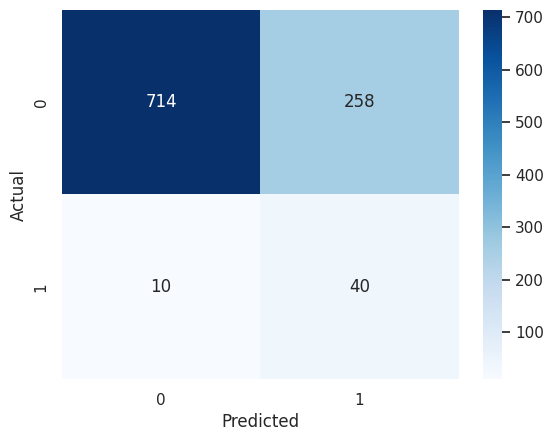


Classification Report:
               precision    recall  f1-score   support

No Stroke (0)       0.99      0.73      0.84       972
   Stroke (1)       0.13      0.80      0.23        50

     accuracy                           0.74      1022
    macro avg       0.56      0.77      0.54      1022
 weighted avg       0.94      0.74      0.81      1022


ROC AUC Score: 0.8390


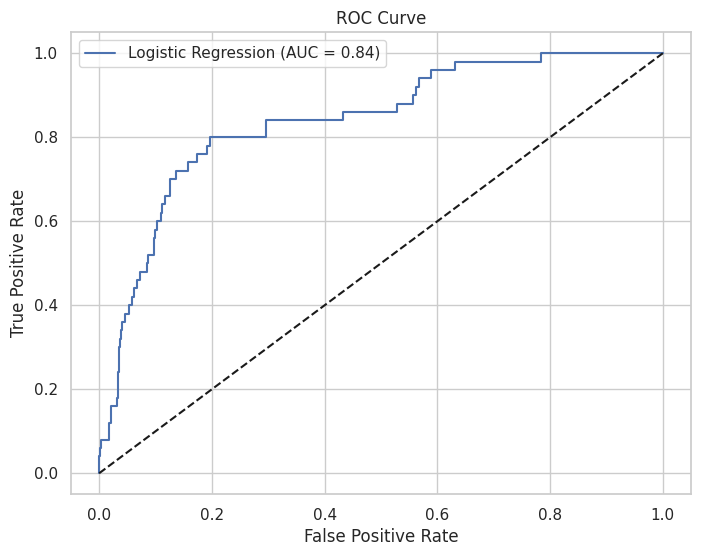

In [7]:
if 'log_reg_pipeline' in locals():
    y_pred = log_reg_pipeline.predict(X_test)
    y_pred_proba = log_reg_pipeline.predict_proba(X_test)[:, 1] # Probabilities for the positive class (stroke=1)

    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy: {accuracy:.4f}")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Stroke (0)', 'Stroke (1)']))

    # ROC AUC Score
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\nROC AUC Score: {roc_auc:.4f}")

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') # Random guessing line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

Additional Cell

--- Evaluating with different thresholds ---

--- Threshold: 0.2 ---
Accuracy: 0.5088
Confusion Matrix (Threshold 0.2):
[[477 495]
 [  7  43]]
Precision (Stroke=1): 0.0799
Recall (Stroke=1): 0.8600
F1-Score (Stroke=1): 0.1463

--- Threshold: 0.3 ---
Accuracy: 0.5959
Confusion Matrix (Threshold 0.3):
[[567 405]
 [  8  42]]
Precision (Stroke=1): 0.0940
Recall (Stroke=1): 0.8400
F1-Score (Stroke=1): 0.1690

--- Threshold: 0.4 ---
Accuracy: 0.6673
Confusion Matrix (Threshold 0.4):
[[640 332]
 [  8  42]]
Precision (Stroke=1): 0.1123
Recall (Stroke=1): 0.8400
F1-Score (Stroke=1): 0.1981

--- Threshold: 0.5 ---
Accuracy: 0.7378
Confusion Matrix (Threshold 0.5):
[[714 258]
 [ 10  40]]
Precision (Stroke=1): 0.1342
Recall (Stroke=1): 0.8000
F1-Score (Stroke=1): 0.2299

--- Threshold: 0.6 ---
Accuracy: 0.8072
Confusion Matrix (Threshold 0.6):
[[787 185]
 [ 12  38]]
Precision (Stroke=1): 0.1704
Recall (Stroke=1): 0.7600
F1-Score (Stroke=1): 0.2784

--- Threshold: 0.7 ---
Accuracy: 0.8454
Confusion

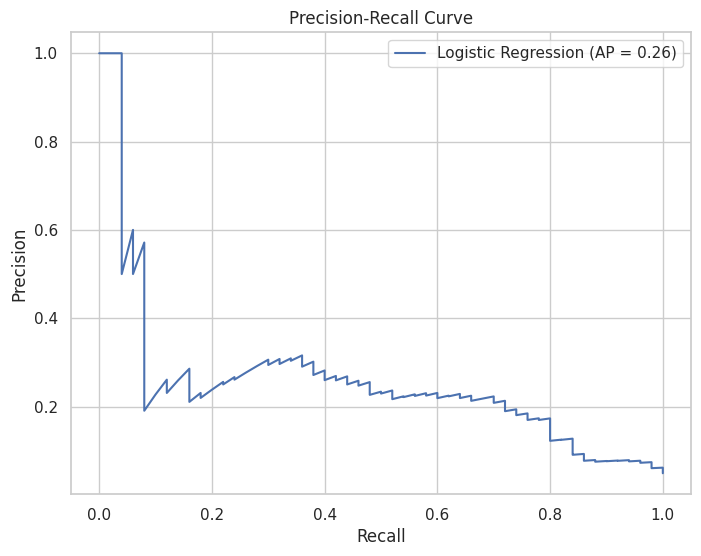

In [8]:
# Cell: Exploring Decision Threshold
if 'log_reg_pipeline' in locals() and 'X_test' in locals() and 'y_test' in locals():
    y_pred_proba = log_reg_pipeline.predict_proba(X_test)[:, 1] # Probabilities for positive class

    print("--- Evaluating with different thresholds ---")
    thresholds_to_try = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    
    for t in thresholds_to_try:
        # Apply new threshold to probabilities
        custom_preds = (y_pred_proba >= t).astype(int)
        
        print(f"\n--- Threshold: {t} ---")
        print(f"Accuracy: {accuracy_score(y_test, custom_preds):.4f}")
        cm_custom = confusion_matrix(y_test, custom_preds)
        # Manually extract TP, FP, TN, FN for recall and precision calculation for class 1
        # Assuming class 1 (Stroke) is the positive class and its index is 1 in confusion matrix
        # Make sure your confusion matrix labels are consistent:
        # TN = cm[0,0], FP = cm[0,1], FN = cm[1,0], TP = cm[1,1]
        tn, fp, fn, tp = cm_custom.ravel() if cm_custom.shape == (2,2) else (0,0,0,0) # Handle cases with no predictions for a class

        precision_class1 = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_class1 = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_class1 = 2 * (precision_class1 * recall_class1) / (precision_class1 + recall_class1) if (precision_class1 + recall_class1) > 0 else 0
        
        print(f"Confusion Matrix (Threshold {t}):\n{cm_custom}")
        print(f"Precision (Stroke=1): {precision_class1:.4f}")
        print(f"Recall (Stroke=1): {recall_class1:.4f}")
        print(f"F1-Score (Stroke=1): {f1_class1:.4f}")

    # Precision-Recall Curve
    from sklearn.metrics import precision_recall_curve, average_precision_score

    precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)

    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, label=f'Logistic Regression (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

Additional Cell


Logistic Regression pipeline with SMOTE trained successfully.

--- Evaluation with SMOTE ---
Accuracy: 0.7387


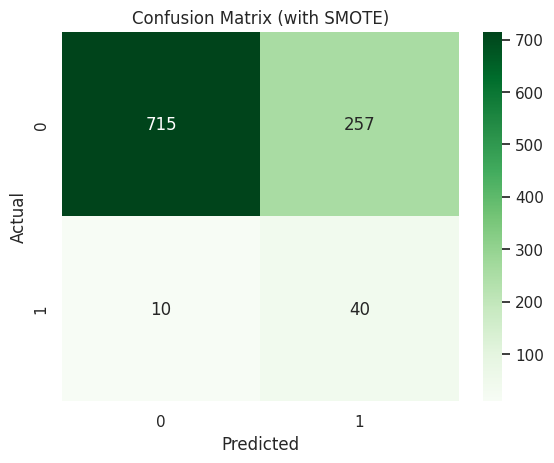

               precision    recall  f1-score   support

No Stroke (0)       0.99      0.74      0.84       972
   Stroke (1)       0.13      0.80      0.23        50

     accuracy                           0.74      1022
    macro avg       0.56      0.77      0.54      1022
 weighted avg       0.94      0.74      0.81      1022

ROC AUC Score (with SMOTE): 0.8386


In [15]:
# Cell: Applying SMOTE (Oversampling)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # Use imblearn's Pipeline

if 'preprocessor' in locals() and 'X_train' in locals() and 'y_train' in locals():
    # Create a new pipeline incorporating SMOTE
    # SMOTE should ONLY be applied to the training data
    log_reg_pipeline_smote = ImbPipeline([
        ('preprocessor', preprocessor), # Preprocessing steps first
        ('smote', SMOTE(random_state=42, k_neighbors=4)),  # Then SMOTE. k_neighbors must be <= n_minority_samples-1
                                                         # You might need to adjust k_neighbors if you have few minority samples after split
        ('classifier', LogisticRegression(solver='liblinear', random_state=42)) 
        # No class_weight='balanced' here as SMOTE handles imbalance
    ])
    
    # Check minority class size before SMOTE for k_neighbors
    # num_minority_samples_train = y_train.sum() # Assuming 1 is minority
    # print(f"Number of minority samples in training set before SMOTE: {num_minority_samples_train}")
    # If num_minority_samples_train is very small (e.g., < k_neighbors+1), SMOTE will fail.

    try:
        # Fit the pipeline with SMOTE
        log_reg_pipeline_smote.fit(X_train, y_train)
        print("\nLogistic Regression pipeline with SMOTE trained successfully.")

        # Make predictions and evaluate
        y_pred_smote = log_reg_pipeline_smote.predict(X_test)
        y_pred_proba_smote = log_reg_pipeline_smote.predict_proba(X_test)[:, 1]

        print("\n--- Evaluation with SMOTE ---")
        print(f"Accuracy: {accuracy_score(y_test, y_pred_smote):.4f}")
        cm_smote = confusion_matrix(y_test, y_pred_smote)
        sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Greens')
        plt.title('Confusion Matrix (with SMOTE)')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        print(classification_report(y_test, y_pred_smote, target_names=['No Stroke (0)', 'Stroke (1)']))
        roc_auc_smote = roc_auc_score(y_test, y_pred_proba_smote)
        print(f"ROC AUC Score (with SMOTE): {roc_auc_smote:.4f}")
    
    except ValueError as e:
        print(f"Error during SMOTE or model training: {e}")
        print("This might be due to too few samples in the minority class for the chosen k_neighbors in SMOTE.")
        print(f"Minority class count in y_train: {y_train.sum()}")

Implement KNN for Classification (Stroke Dataset):
Additional Cell:


KNN model trained successfully (with K=5).

--- KNN Evaluation (K=5) ---
Accuracy: 0.9481


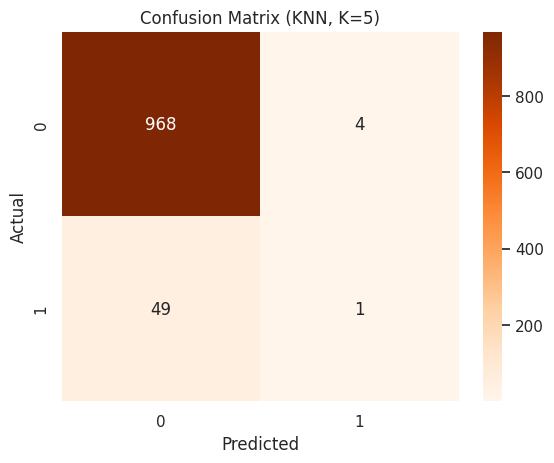

               precision    recall  f1-score   support

No Stroke (0)       0.95      1.00      0.97       972
   Stroke (1)       0.20      0.02      0.04        50

     accuracy                           0.95      1022
    macro avg       0.58      0.51      0.50      1022
 weighted avg       0.92      0.95      0.93      1022

ROC AUC Score (KNN, K=5): 0.6067


In [16]:
# Cell: K-Nearest Neighbors (KNN) Classifier
from sklearn.neighbors import KNeighborsClassifier

if 'preprocessor' in locals() and 'X_train' in locals() and 'y_train' in locals():
    # Create KNN pipeline (preprocessing is crucial for KNN)
    # We will try a few values for n_neighbors later
    knn_pipeline = Pipeline([
        ('preprocessor', preprocessor), # Same preprocessor as before
        ('classifier', KNeighborsClassifier(n_neighbors=5)) # Start with K=5
    ])

    # Train the KNN model
    knn_pipeline.fit(X_train, y_train)
    print("\nKNN model trained successfully (with K=5).")

    # Make predictions
    y_pred_knn = knn_pipeline.predict(X_test)
    y_pred_proba_knn = knn_pipeline.predict_proba(X_test)[:, 1]

    # Evaluate KNN
    print("\n--- KNN Evaluation (K=5) ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
    cm_knn = confusion_matrix(y_test, y_pred_knn)
    sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Oranges')
    plt.title('Confusion Matrix (KNN, K=5)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print(classification_report(y_test, y_pred_knn, target_names=['No Stroke (0)', 'Stroke (1)']))
    roc_auc_knn = roc_auc_score(y_test, y_pred_proba_knn)
    print(f"ROC AUC Score (KNN, K=5): {roc_auc_knn:.4f}")
    
    # Optional: Find a good K using a loop (simple version, better with GridSearchCV later)
    # print("\n--- Finding a good K for KNN ---")
    # k_values = range(1, 20, 2) # Odd numbers to avoid ties, e.g., 1, 3, 5...19
    # roc_auc_scores_knn = []

    # for k_val in k_values:
    #     knn_temp_pipeline = Pipeline([
    #         ('preprocessor', preprocessor),
    #         ('classifier', KNeighborsClassifier(n_neighbors=k_val))
    #     ])
    #     knn_temp_pipeline.fit(X_train, y_train)
    #     y_pred_proba_temp_knn = knn_temp_pipeline.predict_proba(X_test)[:, 1]
    #     roc_auc_scores_knn.append(roc_auc_score(y_test, y_pred_proba_temp_knn))
    
    # plt.figure(figsize=(10,6))
    # plt.plot(k_values, roc_auc_scores_knn, marker='o')
    # plt.xlabel("K Value")
    # plt.ylabel("ROC AUC Score on Test Set")
    # plt.title("KNN Performance for different K values")
    # plt.xticks(k_values)
    # plt.grid(True)
    # plt.show()
    
    # best_k_index = np.argmax(roc_auc_scores_knn)
    # print(f"Best K found: {k_values[best_k_index]} with ROC AUC: {roc_auc_scores_knn[best_k_index]:.4f}")